# Image Classification Using a Pre-trained Neural Network (ResNet18)

## Objective
Use a pre-trained convolutional neural network (ResNet18) to classify images from the internet or your own files. Learn how to load models, preprocess images, and interpret model outputs.

# ResNet in Image Classification

ResNet (short for **Residual Network**) is a deep learning architecture introduced by Microsoft Research in 2015 (He et al., *Deep Residual Learning for Image Recognition*). It is widely used in **image classification** and computer vision tasks.

## 1. The Core Idea: Residual Learning
- Deep neural networks often suffer from the **vanishing gradient problem** and **degradation problem** (accuracy gets worse as the network gets deeper).
- ResNet solves this by introducing **skip connections (residual connections)**.
- Instead of learning a direct mapping \( H(x) \), the network learns a **residual function**:  

$$
F(x) = H(x) - x \quad \Rightarrow \quad H(x) = F(x) + x
$$

&nbsp;&nbsp;**`F(x)`** → the *residual function* (the difference between the desired mapping and the input). <br>
&nbsp;&nbsp;**`H(x)`** → the *desired* output mapping (what the network ideally wants to learn). <br>
&nbsp;&nbsp;**`x`** → the input to the layer (for example, an image feature vector).  

- This makes training much easier because the model only needs to learn the *residual (difference)* from the input, not the full transformation.

## 2. Architecture
- A **residual block** consists of:
  - A few convolutional layers.
  - A skip connection that bypasses these layers and adds the input directly to the output.
- Stacking many such blocks allows the network to be extremely deep (e.g., ResNet-50, ResNet-101, ResNet-152).

## 3. Why It Works for Image Classification
- Allows training of **very deep networks** (over 100 layers) without degradation in performance.
- Achieves high accuracy on benchmarks like **ImageNet**.
- Extracts hierarchical features (edges → textures → objects) more effectively due to depth.

## 4. Key Achievements
- ResNet won the **ImageNet 2015 competition** with a top-5 error of only 3.57%.
- It became the backbone for many computer vision tasks (detection, segmentation, recognition).

---
✅ **In short:**  
ResNet is a neural network architecture that uses **skip connections** to enable very deep networks, making it one of the most powerful and influential models for image classification and beyond.

# Import packages

In [1]:
import torch
from torchvision import models, transforms
from PIL import Image
import requests
import matplotlib.pyplot as plt

#supress all warnings
import warnings
warnings.filterwarnings("ignore")

## Part 1 Classify dog Image

Load a dog image from the internet and classify it using ResNet18.

Dog Images were downloaded from [American Kennel Club](https://www.akc.org/). You can first search the breed of dog you wants to download (for example golden retriever), click the image and right click to choose **copy image address** to extract URL for the image.

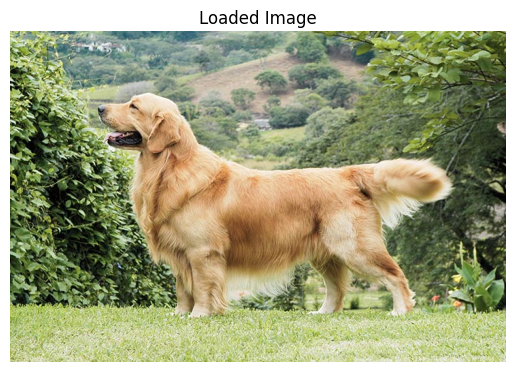

In [19]:
# Load and preprocess image

# load an image from the internet
url = "https://www.akc.org/wp-content/uploads/2017/11/Golden-Retriever-standing-outdoors.jpg"  # golden_retriever
#url = "https://www.akc.org/wp-content/uploads/2017/11/Labrador-Retriever-On-White-01.jpg"  # labrador_retriever
#url="https://www.akc.org/wp-content/uploads/2017/11/German-Shepherd-on-White-00.jpg" # german_Shepherd
#url="https://www.akc.org/wp-content/uploads/2017/11/Siberian-Husky-standing-outdoors-in-the-winter.jpg" # husky. It was predicted as Eskimo dog
#url="https://www.akc.org/wp-content/uploads/2017/11/bull-terrier-on-white-10.jpg" # bull terrier. it was predicted as Great Dane
#url="https://www.akc.org/wp-content/uploads/2017/11/Chihuahua-at-the-AKC-National-Championship.jpg" # Chihuahua

img = Image.open(requests.get(url, stream=True).raw).convert("RGB") # # open with PIL and ensure it's RGB

# Save image
img.save("images/dogs/golden_retriever.jpg")

# alternatively, you can also load the image from your local directory

#img = Image.open("images/dogs/golden_retriever.jpg")

#Define preprocessing transformations for the image

transform = transforms.Compose([
    transforms.Resize(256),    # resize so shortest side = 256 px
    transforms.CenterCrop(224), #crop the center to 224x224 (standard for ResNet)
    transforms.ToTensor(),      # convert PIL image (H x W x C) → Tensor (C x H x W), scale [0–255] → [0–1]
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # normalize with ImageNet mean
                         std=[0.229, 0.224, 0.225])  # normalize with ImageNet std
])

## Apply transforms and add batch dimension
input_tensor = transform(img).unsqueeze(0)  # shape becomes (1, 3, 224, 224)

# Display image
plt.imshow(img)
plt.axis('off')
plt.title("Loaded Image")
plt.show()

In [20]:
# Load a pre-trained ResNet-18 model trained on ImageNet

model = models.resnet18(pretrained=True)

# set the model to evaluation mode
model.eval()

# Make prediction (no gradient calculation needed)
with torch.no_grad():
    output = model(input_tensor) #forward pass: get raw prediction scores (logits) for 1000 ImageNet classes
    predicted_class = output.argmax(dim=1).item() #find the index of the class with the highest score

# Load ImageNet class labels from Github
labels_url = "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt"

# download and split into list of 1000 class names
labels = requests.get(labels_url).text.strip().split("\n")

# Print the top predicted class for the input image

print(f"Predicted class: {labels[predicted_class]}")

Predicted class: golden retriever


# Note:

### To imporve the performance, we can switch from ResNet-18 to a deeper/wider ResNet for example, ResNet-50/101, ResNeXt-50 (32×4d), or Wide-ResNet-50-2. We can also fine-tune the model to improve the performance. 

### Display top N predictions
Instead of outputting only the top prediction, we can also display the top N predictions with their probabilities.

We will open the Husky dog image where the top prediction is incorrect. The result shows that the second prediction is correct (Siberian Husky) with a probability of 24%.

In [22]:
import torch
import torch.nn.functional as F
import torchvision.models as models
import requests

img = Image.open("images/dogs/husky.jpg")

## Apply transforms and add batch dimension

input_tensor = transform(img).unsqueeze(0)  # shape becomes (1, 3, 224, 224)

# Load a pre-trained ResNet-18 model trained on ImageNet
model = models.resnet18(pretrained=True)

# Set the model to evaluation mode
model.eval()

# Make prediction (no gradient calculation needed)
with torch.no_grad():
    output = model(input_tensor)  # forward pass: logits for 1000 classes
    probs = F.softmax(output[0], dim=0)  # convert logits → probabilities

    # Get top 3 predictions
    top3_prob, top3_idx = torch.topk(probs, 3)

# Load ImageNet class labels from GitHub
labels_url = "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt"

labels = requests.get(labels_url).text.strip().split("\n")

# Print the top 3 predicted classes with probability
print("Top 3 predictions:")
for i in range(3):
    print(f"{labels[top3_idx[i]]}: {top3_prob[i].item():.4f}")

Top 3 predictions:
Eskimo dog: 0.7273
Siberian husky: 0.2525
malamute: 0.0191


## Part 2 Classify other images

🧠 **What ResNet-18 is trained on**

- The model you’re using (`models.resnet18`) is trained on **ImageNet**.
- ImageNet has **1,000 categories**, not just dogs.
- These include:
  - **Animals** (cats, birds, fish, insects, etc.)
  - **Objects** (cars, bicycles, chairs, keyboards, TVs, phones, etc.)
  - **Scenes & instruments** (street signs, musical instruments, tools, etc.)

So ResNet-18 can predict any of those **1,000 ImageNet classes**. Dogs just happen to be a large portion (about 118 breeds).

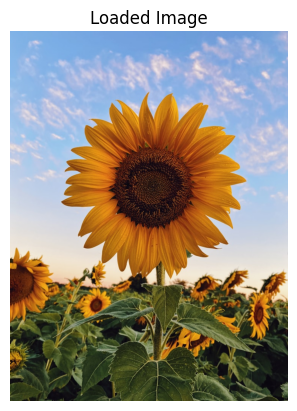

In [23]:
# Apply ResNet to other images

# sunflower
url = "https://images.unsplash.com/photo-1597848212624-a19eb35e2651?q=80&w=735&auto=format&fit=crop&ixlib=rb-4.1.0&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D"  #sunflower

# eagle
#url="https://media.istockphoto.com/id/108221750/photo/bald-eagle-perched-on-stump-alaska.jpg?s=2048x2048&w=is&k=20&c=46phb8LQAlFKYm4T-KJCGkkYKvkH3fUCKvB3pKYtcTk="

# chair
#url="https://www.worthingtondirect.com/media/catalog/product/4/4/4400.jpg?quality=80&bg-color=255,255,255&fit=bounds&height=&width=&canvas=:"

# car
#url="https://media.istockphoto.com/id/1150425295/photo/3d-illustration-of-generic-hatchback-car-perspective-view.jpg?s=1024x1024&w=is&k=20&c=bm5iqq6Vq1hYtlety6VLiga7hITUCDpr46qhbfXRs_4="

img = Image.open(requests.get(url, stream=True).raw).convert("RGB") # open with PIL and ensure it's RGB

# Save image
img.save("images/others/sunflower.jpg")

# alternatively, you can also load the image from your local directory
#img = Image.open("images/others/sunflower.jpg")

#Define preprocessing transformations for the image

transform = transforms.Compose([
    transforms.Resize(256),    # resize so shortest side = 256 px
    transforms.CenterCrop(224), #crop the center to 224x224 (standard for ResNet)
    transforms.ToTensor(),      # convert PIL image (H x W x C) → Tensor (C x H x W), scale [0–255] → [0–1]
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # normalize with ImageNet mean
                         std=[0.229, 0.224, 0.225])  # normalize with ImageNet std
])

## Apply transforms and add batch dimension
input_tensor = transform(img).unsqueeze(0)  # shape becomes (1, 3, 224, 224)

# Display image
plt.imshow(img)
plt.axis('off')
plt.title("Loaded Image")
plt.show()

In [24]:
# Load a pre-trained ResNet-18 model trained on ImageNet
model = models.resnet18(pretrained=True)

# set the model to evaluation mode
model.eval()

# Make prediction (no gradient calculation needed)
with torch.no_grad():
    output = model(input_tensor) #forward pass: get raw prediction scores (logits) for 1000 ImageNet classes
    predicted_class = output.argmax(dim=1).item() #find the index of the class with the highest score

# Load ImageNet class labels from Github
labels_url = "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt"

# download and split into list of 1000 class names
labels = requests.get(labels_url).text.strip().split("\n")

# Print the top predicted class for the input image
print(f"Predicted class: {labels[predicted_class]}")

Predicted class: daisy


Note: The model did not predict sunflower correctly.

## Part 3 Process multiple images at once

The below script runs ResNet-18 on all images in a folder, then saves them a DataFrame with two columns: filename and prediction. It also prints the head and (optionally) writes to CSV.

In [25]:
import os
from pathlib import Path
import requests
import torch
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
import pandas as pd
import torch.nn.functional as F  # only needed if you later want probabilities

# ---------- Settings ----------
folder = Path("images/dogs")        # <-- change to your folder

patterns = ("*.jpg", "*.jpeg", "*.png", "*.bmp", "*.webp")

# #Define preprocessing transformations for the image
transform = transforms.Compose([
    transforms.Resize(256),                 
    transforms.CenterCrop(224),            
    transforms.ToTensor(),                 
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]), 
])

# Load ImageNet class labels from Github
labels_url = "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt"
labels = requests.get(labels_url).text.strip().split("\n")

# Load a pre-trained ResNet-18 model trained on ImageNet
model = models.resnet18(pretrained=True)
model.eval()

# ---------- Helper ----------
def predict_image(path: Path) -> str:
    """Return top class label for a single image path."""
    img = Image.open(path).convert("RGB")
    x = transform(img).unsqueeze(0) 
    with torch.no_grad():
        logits = model(x)
        idx = logits.argmax(dim=1).item()
    return labels[idx]

# ---------- Collect files ----------
files = []
for pat in patterns:
    files.extend(folder.glob(pat))
files = sorted(files)

# ---------- Run predictions ----------
records = []
for p in files:
    try:
        pred = predict_image(p)
        records.append({"filename": p.name, "prediction": pred})
    except Exception as e:
        # Skip unreadable files but record the error if you like:
        records.append({"filename": p.name, "prediction": f"ERROR: {e}"})
        continue

# ---------- DataFrame ----------
df = pd.DataFrame(records, columns=["filename", "prediction"])
print(df.head(10))

# Optional: save to CSV
# df.to_csv("predictions.csv", index=False)

                 filename          prediction
0        bull_terrier.jpg          Great Dane
1           chihuahua.jpg           Chihuahua
2     german_shepherd.jpg     German shepherd
3    golden_retriever.jpg    golden retriever
4               husky.jpg          Eskimo dog
5  labrador_retriever.jpg  Labrador retriever


# 📝 Take-Home Assignment: Try Your Own Image Classification

## Instructions

1. **Download and Save Images**  
   - Select at least **five images** of your choice (from the internet or your own photos).  
   - Save all images in a folder named: `/images/asgn`.  

2. **Run Classification**  
   - Use a **pre-trained ResNet-18 model** to classify each image.  
   - Include your **code** in the notebook section provided below.  

3. **Write a Short Report**  
   - Prepare a **Word document (1–2 pages)** that addresses the following:  
     - Which images did you use? Provide a brief description and insert the images in your report.  
     - What class did the model predict for each image?  
     - What was the overall accuracy of the predictions across your chosen images?  
     - What did you learn from this exercise about image classification and the use of pre-trained models? 
     - How can you imporve the accuracy of the prediction?

In [ ]:
# Try your own image
# img = Image.open("your_image.jpg")
# input_tensor = transform(img).unsqueeze(0)
# with torch.no_grad():
#     output = model(input_tensor)
#     predicted_class = output.argmax(dim=1).item()
# print(f"Predicted class: {labels[predicted_class]}")